In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # seaborn style
sns.set(font_scale=1)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 명령문 결과 다 보여주기

#------------------------
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
import os
print(os.listdir("../input"))

['merchants.csv', 'Data_Dictionary.xlsx', 'historical_transactions.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
%%time
merchant = pd.read_csv('../input/merchants.csv')
new_mct_trans = pd.read_csv('../input/new_merchant_transactions.csv')
train = pd.read_csv('../input/train.csv', parse_dates=["first_active_month"])
test = pd.read_csv('../input/test.csv', parse_dates=["first_active_month"])

CPU times: user 6.75 s, sys: 940 ms, total: 7.69 s
Wall time: 7.74 s


# EDA
1) train <br>
2) merchant <br>
3) trans <br>
4) new_mct_trans

## 2. merchant
0) merchant_id <br>
1) merchant_category_id <br>
2) subsector_id <br>
3) category_1/2 : trans에도 있는 feature<br>
4) category_4 <br>
5) city_id/state_id <br>
6) merchant_group_id <br>
7) numerical_1/2 <br>
8) most_recent_sales_range <br>
9) most_recent_purchases_range <br>
10) avg_sales_lag3/6/12 <br>
11) avg_purchases_lag3/6/12 <br>
12) avg_active_months_lag3/6/12

In [4]:
merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

전체 334696행으로 이루어져있다. <br>
결측치도 좀 있다. 결측치 있는 features : [`avg_sales_lag3`, `avg_sales_lag6`, `avg_sales_lag12`, `category_2`]

In [5]:
merchant.nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       954
numerical_2                       947
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3372
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4507
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5009
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

- merchant_id

전체 행이 334696인데 334633개만 unique하다. 334696-334633=63개가 중복되는 정보인지 확인하겠다.

In [6]:
merchant['merchant_id'].value_counts().to_frame(name='nunique').groupby('nunique')['nunique'].sum()

nunique
1    334592
2        60
4        44
Name: nunique, dtype: int64

In [7]:
334592 + 60 + 44

334696

중복되는 merchant_id는 104개이다. 이 중 60개는 2번, 44개는 4번 중복됐다.<br>
중복된 merchant_id가 나타나는 행에 차이가 있는지 확인해보겠다.

In [8]:
num_mct_df = merchant['merchant_id'].value_counts().to_frame(name='nunique')
rep_mct_df = num_mct_df[num_mct_df['nunique']>1]
rep_mct_id = rep_mct_df.index

In [9]:
for i in range(3):
    merchant[merchant['merchant_id'] == rep_mct_id[i]]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
210653,M_ID_c2b9ac2ea4,69907,554,25,-0.057471,-0.057471,Y,D,E,1.11,0.702381,3,1.11,0.702381,3,1.11,0.702381,3,Y,-1,-1,NaN
210654,M_ID_c2b9ac2ea4,35,554,25,-0.057471,-0.057471,Y,D,E,1.11,0.702381,3,1.11,0.702381,3,1.11,0.702381,3,Y,-1,-1,NaN
210655,M_ID_c2b9ac2ea4,35,554,25,-0.057471,-0.057471,Y,C,D,2.13,1.806607,3,2.02,1.572673,6,1.77,1.491291,12,Y,-1,-1,NaN
210656,M_ID_c2b9ac2ea4,69907,554,25,-0.057471,-0.057471,Y,C,D,2.13,1.806607,3,2.02,1.572673,6,1.77,1.491291,12,Y,-1,-1,NaN


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
7584,M_ID_dbbf07ebf0,69462,278,37,-0.057471,-0.057471,N,E,E,52.08,45.333333,3,75.36,68.000000,6,82.95,70.4500,10,Y,17,22,4.0
7585,M_ID_dbbf07ebf0,35,278,37,-0.057471,-0.057471,N,E,E,52.08,45.333333,3,75.36,68.000000,6,82.95,70.4500,10,Y,17,22,4.0
7586,M_ID_dbbf07ebf0,69462,278,37,-0.047556,-0.047556,N,D,D,1.12,1.132979,3,1.23,1.234043,6,1.30,1.3125,12,Y,17,22,4.0
7587,M_ID_dbbf07ebf0,35,278,37,-0.047556,-0.047556,N,D,D,1.12,1.132979,3,1.23,1.234043,6,1.30,1.3125,12,Y,17,22,4.0


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
228274,M_ID_d123532c72,35,385,17,-0.057471,-0.057471,Y,D,E,0.81,1.000000,3,0.99,1.243333,6,1.33,1.615000,12,Y,-1,-1,NaN
228275,M_ID_d123532c72,49094,385,17,-0.057471,-0.057471,Y,D,E,0.81,1.000000,3,0.99,1.243333,6,1.33,1.615000,12,Y,-1,-1,NaN
228276,M_ID_d123532c72,35,385,17,-0.057471,-0.057471,Y,D,C,0.88,0.943233,3,0.79,0.899183,6,0.65,0.700159,12,Y,-1,-1,NaN
228277,M_ID_d123532c72,49094,385,17,-0.057471,-0.057471,Y,D,C,0.88,0.943233,3,0.79,0.899183,6,0.65,0.700159,12,Y,-1,-1,NaN


merchant_group_id가 2가지로 나누어져있고, 판매량, 판매수익 등의 계산 결과도 2가지로 나뉜다. <br>
왜 merchant_group_id가 2가지로 나누어질까? 중간에 업종을 변경했나? 아니면 하나의 여러 업종에 걸쳐있는 상인인가? <br>
그리고 왜 판매량과 판매 수익에 대한 정보도 변할까? last active month를 다르게 정하고 계산한걸까? <br>
history를 통해 `last_active_month` 피쳐도 추가해야겠다. 이를 통해 얼마나 최신 정보인지도 알 수 있을 것 같다. <br>
<br>
그런데 이렇게만 봐서는 다른 값을 갖는 column에 뭐가있는지 모르겠다. `merchant_id`가 같을 때 다른 값을 갖는 column들을 찾자. 

In [10]:
def search_diff(df, ref_col):
    """이 함수는 ref_col이 같은 records를 비교해서, 서로 다른 값을 나타내는 column을 찾아줍니다.
        ref_col에서 중복되는 값이 나타나는 경우만 봅니다."""
    columns = {}
    n_col = df.columns.values.size
    num_ref_col = df[ref_col].value_counts().to_frame(name='nunique')
    rep_ref_col_df = num_ref_col[num_ref_col['nunique']>1]
    rep_ids = rep_ref_col_df.index # ref_col에서 중복되는 값이 나타나는 값들

    for id in rep_ids :
        records = df[df[ref_col]==id]
        for i in range(n_col):
            col = records.columns[i]
            if records[col].nunique() != 1 :
                if col in columns :
                    columns[col] += 1
                else :
                    columns[col] = 1
    return columns

In [11]:
search_diff(merchant, 'merchant_id')

{'merchant_group_id': 12,
 'most_recent_sales_range': 30,
 'most_recent_purchases_range': 33,
 'avg_sales_lag3': 40,
 'avg_purchases_lag3': 41,
 'avg_sales_lag6': 41,
 'avg_purchases_lag6': 41,
 'active_months_lag6': 14,
 'avg_sales_lag12': 41,
 'avg_purchases_lag12': 41,
 'active_months_lag12': 24,
 'category_2': 17,
 'numerical_1': 34,
 'numerical_2': 30,
 'active_months_lag3': 7,
 'merchant_category_id': 1,
 'city_id': 1,
 'state_id': 1}

거의 모든 칼럼에서 다른 값이 나온다. 심지어 `city_id`, `state_id`도 다른 merchant가 있다. <br>
중복되는 `merchant_id`는 왜 이런식으로 정보가 바뀐 걸까? <br>
그게 `last_active_month`가 달라서 일 수도 있는데, `last_active_month`를 알 수 있는 방법은 없어보인다. <br>
중복되는 `merchant_id`를 어떻게 처리할 지 생각해보자.

> https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/72924#latest-463601 -> 그냥 하나만 남겨놓고 해라.

- merchant_category_id

In [12]:
merchant['merchant_category_id'].nunique()

324

`merchant_category_id`는 324가지이다.

(0, 5000)

(0, 2000)

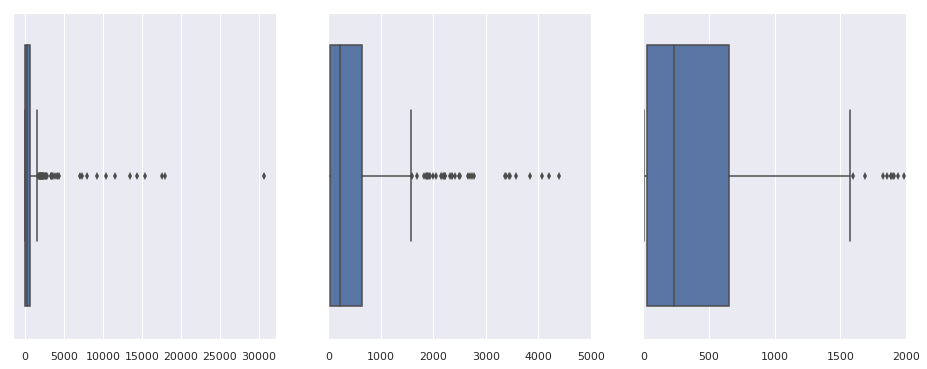

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
sns.boxplot(merchant['merchant_category_id'].value_counts().values, ax=axes[0])
sns.boxplot(merchant['merchant_category_id'].value_counts().values, ax=axes[1]).set_xlim(0,5000)
sns.boxplot(merchant['merchant_category_id'].value_counts().values, ax=axes[2]).set_xlim(0,2000)

In [14]:
np.quantile(merchant['merchant_category_id'].value_counts().values, q=(0.25, 0.5, 0.75))
min(merchant['merchant_category_id'].value_counts()), max(merchant['merchant_category_id'].value_counts())

array([ 29.  , 230.5 , 650.75])

(1, 30666)

각 `merchant_category_id`마다 해당 상인의 수를 구해봤다. 1개의 상점만 갖는 카테고리부터 30666개의 상점이 갖는 카테고리까지 분포해있다. <br>
merchant의 특징으로 볼 수 있겠다.

- subsector_id

`merchant_category_id`와 `subsector_id`가 계층적 구조를 갖는지 알아볼 것.

In [15]:
merchant['subsector_id'].nunique()

41

`subsector_id`는 41가지이다.

In [16]:
merchant.groupby('subsector_id')['merchant_category_id'].nunique().sum()

324

`subsector_id`마다 갖고있는 `merchant_category_id`가 몇가지인지 세서 더했더니 `merchant_category_id`의 가짓수만큼 나왔다.<br>
`subsector_id` > `merchant_category_id`가 계층적 구조를 갖는다는 의미이다. <br>
개수가 우연히 일치했다고 주장할 수 있으므로 `subsector_id`별로 unique한 `merchant_category_id`를 뽑았을 때 324개가 나오는지 확인하겠다.

In [17]:
merchant.groupby('subsector_id')['merchant_category_id'].nunique().sort_values().reset_index(name='n_merchant_category')

,subsector_id,n_merchant_category
0,-1,1
1,15,1
2,14,1
3,13,1
4,40,1
5,28,1
6,24,1
7,39,1
8,30,1
9,11,2


-1은 뭐지? -1 안에 들어있는 category는 어떤 숫자지?

In [18]:
# subsector와 mct_cate의 계층구조 matching dict
mct_cate_hier_dict = {}

for x in merchant['subsector_id'].unique():
    cate_id = merchant[merchant['subsector_id'] == x]['merchant_category_id'].unique()
    mct_cate_hier_dict[x] = list(cate_id)

mct_cate_hier_dict

{9: [792, 806, 556, 340, 225, 514, 685],
 20: [840, 529, 2, 342, 180, 273, 702, 458, 396, 69, 351, 714],
 1: [690, 419, 206, 829],
 21: [222,
  309,
  456,
  692,
  411,
  356,
  215,
  443,
  9,
  40,
  115,
  667,
  201,
  223,
  71,
  140],
 27: [87,
  369,
  427,
  63,
  497,
  68,
  779,
  432,
  884,
  531,
  518,
  289,
  422,
  357,
  276,
  834,
  417,
  319,
  126,
  889],
 29: [813,
  81,
  703,
  891,
  178,
  544,
  33,
  774,
  414,
  166,
  607,
  557,
  650,
  498,
  110,
  843,
  568,
  748,
  21,
  795,
  157,
  145,
  409,
  614,
  879,
  593,
  386,
  839,
  31,
  187,
  664,
  523,
  881,
  448,
  757],
 18: [45, 412, 373, 669, 363, 737, 415, 482],
 37: [278, 80, 842, 637, 509],
 10: [298, 796, 333, 119, 198],
 33: [705, 613, 642],
 7: [511,
  781,
  591,
  652,
  451,
  105,
  391,
  384,
  209,
  561,
  216,
  312,
  114,
  873,
  671,
  320,
  16,
  181,
  717,
  598,
  246,
  519,
  265,
  57,
  534,
  478,
  36,
  38,
  587,
  438,
  400],
 15: [437],
 34: [36

In [19]:
mct_cate_hier_dict[-1]

[-1]

`subsector_id`와 `merchant_category_id`모두 -1인 경우가 있는데 이건 아무래도 missing value인 것 같다.

In [20]:
num_mct_cate = []
for k, v in mct_cate_hier_dict.items():
     num_mct_cate += v
num_mct_cate

[792,
 806,
 556,
 340,
 225,
 514,
 685,
 840,
 529,
 2,
 342,
 180,
 273,
 702,
 458,
 396,
 69,
 351,
 714,
 690,
 419,
 206,
 829,
 222,
 309,
 456,
 692,
 411,
 356,
 215,
 443,
 9,
 40,
 115,
 667,
 201,
 223,
 71,
 140,
 87,
 369,
 427,
 63,
 497,
 68,
 779,
 432,
 884,
 531,
 518,
 289,
 422,
 357,
 276,
 834,
 417,
 319,
 126,
 889,
 813,
 81,
 703,
 891,
 178,
 544,
 33,
 774,
 414,
 166,
 607,
 557,
 650,
 498,
 110,
 843,
 568,
 748,
 21,
 795,
 157,
 145,
 409,
 614,
 879,
 593,
 386,
 839,
 31,
 187,
 664,
 523,
 881,
 448,
 757,
 45,
 412,
 373,
 669,
 363,
 737,
 415,
 482,
 278,
 80,
 842,
 637,
 509,
 298,
 796,
 333,
 119,
 198,
 705,
 613,
 642,
 511,
 781,
 591,
 652,
 451,
 105,
 391,
 384,
 209,
 561,
 216,
 312,
 114,
 873,
 671,
 320,
 16,
 181,
 717,
 598,
 246,
 519,
 265,
 57,
 534,
 478,
 36,
 38,
 587,
 438,
 400,
 437,
 360,
 683,
 560,
 195,
 108,
 171,
 695,
 332,
 430,
 651,
 605,
 551,
 117,
 383,
 686,
 358,
 183,
 292,
 630,
 19,
 111,
 387,
 763,
 

In [21]:
len(set(num_mct_cate)) # set은 중복되는 elements를 1번만 씀

324

서로 다른 324개의 `merchant_category_id`가 나왔다. 계층구조 확인!<br>
`subsector_id`, `merchant_category_id`처럼 계층 구조가 있는 경우, 상위 데이터를 쓸 지 하위 데이터를 쓸 지 결정해야 한다.

- merchant_group_id

In [22]:
merchant['merchant_group_id'].nunique()
sum(merchant['merchant_group_id'] == -1)

109391

0

`merchant_group_id`도 `subsector_id`, `merchant_category_id`와 계층 구조가 있을 수 있으므로 확인하겠다.

In [23]:
merchant.groupby('subsector_id')['merchant_group_id'].nunique().sum()
merchant.groupby('merchant_category_id')['merchant_group_id'].nunique().sum()

149970

178544

계층구조 없음! 따라서 `merchant_group_id`는 merchant의 독립적인 특성으로 볼 수 있다.

- city_id/state_id

당연히 얘네도 계층구조 갖겠지요

In [24]:
merchant['city_id'].nunique()
merchant['state_id'].nunique()

271

25

In [25]:
merchant['city_id'].unique()
merchant['state_id'].unique()

array([242,  22,  -1, 160,  60, 248,  88, 158,  11, 143, 282, 123, 126,
       272,  85, 140,  62,  63, 323, 200, 310,  69, 239,  17,   4, 231,
       124,   3, 301,  87, 186, 150, 156, 161, 209,  25, 303, 101,  12,
       147,  44, 254,  58,  32,  53,  96, 213, 214, 125, 229, 168,  30,
       204,  94, 210, 137, 165, 187, 223, 238, 205, 157, 114, 276,  76,
       233, 183, 277, 212, 247, 167, 274, 343, 251, 283,   9,  21,  84,
         7, 297, 291,  33, 246, 169, 228, 201, 181, 253, 159, 172,  47,
         6, 113, 206,  51,  82,  80,  36, 215, 259, 314,  98, 295, 174,
       211, 339, 250, 307,  24,  48,  89, 341, 275,  66, 224, 189, 230,
       100, 142, 342, 135, 105, 115,  64, 153, 245, 299,  14, 184, 208,
       235, 219, 108, 119, 329, 163, 139, 220,  52,  10, 285, 337, 308,
       300, 155, 256, 271,   1, 333, 116, 136, 281,  56, 218,   8, 340,
       261, 146,  38, 106,  46, 325,  42, 226, 268,  90, 129, 289, 270,
        91, 130, 311, 216, 294, 278, 171, 336, 117, 148, 255, 28

array([ 9, 16,  5, -1, 21, 15, 20, 23, 18, 19,  4,  8,  1,  2, 22,  7,  6,
       13, 10, 24, 11, 14,  3, 12, 17])

`city_id`랑 `state_id`가 다 숫자(id)로 생겨서 matching 시켜주는 dict를 만들어야겠다.

In [26]:
# state와 city의 계층구조 matching dict
mct_loc_hier_dict = {}

for x in merchant['state_id'].unique():
    cate_id = merchant[merchant['state_id'] == x]['city_id'].unique()
    mct_loc_hier_dict[x] = list(cate_id)

mct_loc_hier_dict

{9: [242,
  -1,
  272,
  140,
  62,
  63,
  69,
  231,
  186,
  209,
  96,
  213,
  168,
  238,
  276,
  233,
  183,
  167,
  274,
  283,
  21,
  7,
  297,
  291,
  159,
  6,
  314,
  98,
  295,
  174,
  339,
  250,
  24,
  48,
  189,
  230,
  105,
  115,
  299,
  184,
  329,
  163,
  139,
  220,
  285,
  155,
  271,
  333,
  116,
  340,
  261,
  106,
  325,
  129,
  311,
  294,
  117,
  255,
  318,
  327,
  151,
  78,
  49,
  23,
  191,
  128,
  70,
  131,
  198,
  309,
  188,
  28,
  279,
  83,
  13,
  173,
  265,
  111,
  77],
 16: [22,
  60,
  88,
  -1,
  3,
  32,
  214,
  125,
  210,
  343,
  9,
  47,
  51,
  224,
  100,
  308,
  226,
  270,
  336,
  110,
  65,
  175,
  267,
  68,
  71,
  104,
  312,
  328,
  345],
 5: [-1,
  143,
  310,
  150,
  12,
  44,
  247,
  201,
  181,
  256,
  289,
  278,
  260,
  240,
  287,
  269,
  313,
  145],
 -1: [-1],
 21: [160,
  223,
  -1,
  259,
  89,
  119,
  281,
  268,
  171,
  39,
  306,
  234,
  182,
  194,
  26,
  120,
  178],
 15: [248,
 

-1이 다 들어 가 있다. 그리고 `state_id`=-1인 경우엔 `city_id`가 -1뿐이다. missing value인 것 같다.

In [27]:
merchant.groupby('state_id')['city_id'].nunique().sum()

295

unique한 `city_id`는 271개인데 295개가 나왔으므로, 중복되는 `city_id`를 갖는 `state_id`들이 있다. <br>
어떤 `state_id`들이 같은 `city_id`를 공유하는지 확인하자. <br>
`city_id`별로 `state_id`가 몇 개씩 나오나 확인하면 된다.

In [28]:
merchant.groupby('city_id')['state_id'].nunique().to_frame(name='number of states')
merchant.groupby('city_id')['state_id'].nunique().value_counts().to_frame()

,number of states
city_id,
-1,25
1,1
2,1
3,1
4,1
6,1
7,1
8,1
9,1


,state_id
1,270
25,1


`city_id`=-1인 경우가 25가지 이다. 따라서 `state_id`=-1인 경우를 제외한 다른 24개의 state에서 city를 모르는 경우가 있다는 의미이다. 어떤 state에서 `city_id`=-1 값을 가질까?

In [29]:
city_minus_1 = merchant[merchant['city_id'] == -1]['state_id'].unique()
np.sort(city_minus_1)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

위의 `state_id`가 `city_id`=-1을 포함하는 곳이다. <br>
따라서 `city_id`=-1 때문에 `state_id`와 `city_id`를 완벽한 계층구조로 볼 수는 없을 것 같다. [더 생각해볼 것] 

- category_1/2/4

In [30]:
merchant['category_1'].nunique()
merchant['category_2'].nunique()
merchant['category_4'].nunique()

2

5

2

In [31]:
merchant['category_1'].unique()
merchant['category_2'].unique()
merchant['category_4'].unique()

array(['N', 'Y'], dtype=object)

array([ 1.,  5., nan,  2.,  3.,  4.])

array(['N', 'Y'], dtype=object)

In [32]:
# category_2의 missing value
'category_2의 missing value는 전체 데이터의 {}% 이다.'.format(round(merchant['category_2'].isnull().sum()/merchant.shape[0] * 100, 2))

'category_2의 missing value는 전체 데이터의 3.55% 이다.'

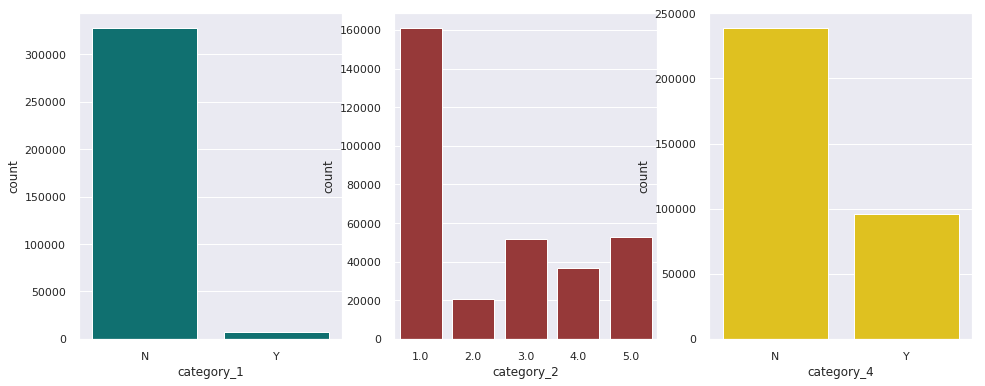

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
sns.countplot(merchant['category_1'], color='teal', ax=axes[0])
sns.countplot(merchant['category_2'], color='brown', ax=axes[1])
sns.countplot(merchant['category_4'], color='gold', ax=axes[2])

category_1 : N>>>>>Y이므로 Y인 merchant의 특징을 찾으면 좋을 것 같다. <br>
category_2 : 1>>>>3,4,5>2 <br>
category_4 : N>>Y

- numerical_1/2

In [34]:
merchant[['numerical_1', 'numerical_2']].describe()

,numerical_1,numerical_2
count,334696.000000,334696.000000
mean,0.011476,0.008103
std,1.098154,1.070497
min,-0.057471,-0.057471
25%,-0.057471,-0.057471
50%,-0.057471,-0.057471
75%,-0.047556,-0.047556
max,183.735111,182.079322


`numerical_1`과 `numerical_2`의 분포가 비슷해보인다. 

Text(0.5, 1.0, 'violinplot: numerical_1')

Text(0.5, 1.0, 'boxplot: numerical_1')

Text(0.5, 1.0, 'violinplot: numerical_2')

Text(0.5, 1.0, 'boxplot: numerical_2')

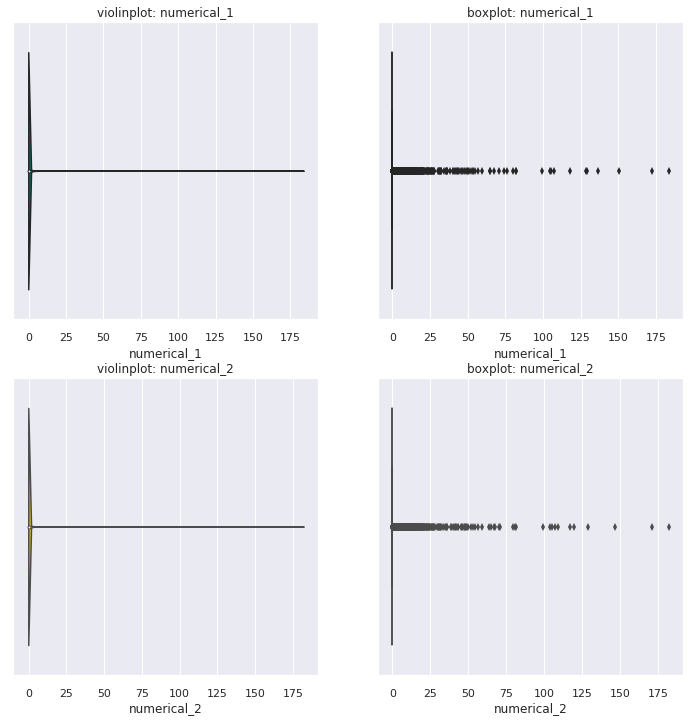

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
sns.violinplot(merchant['numerical_1'], ax=axes[0,0], color='teal').set_title('violinplot: numerical_1')
sns.boxplot(merchant['numerical_1'], ax=axes[0,1], color='teal').set_title('boxplot: numerical_1')
sns.violinplot(merchant['numerical_2'], ax=axes[1,0], color='gold').set_title('violinplot: numerical_2')
sns.boxplot(merchant['numerical_2'], ax=axes[1,1], color='gold').set_title('boxplot: numerical_2')

너무 작은 값쪽에 몰려있다. log 변환 해보자.

Text(0.5, 1.0, 'violinplot: numerical_1')

Text(0.5, 1.0, 'boxplot: numerical_1')

Text(0.5, 1.0, 'violinplot: numerical_2')

Text(0.5, 1.0, 'boxplot: numerical_2')

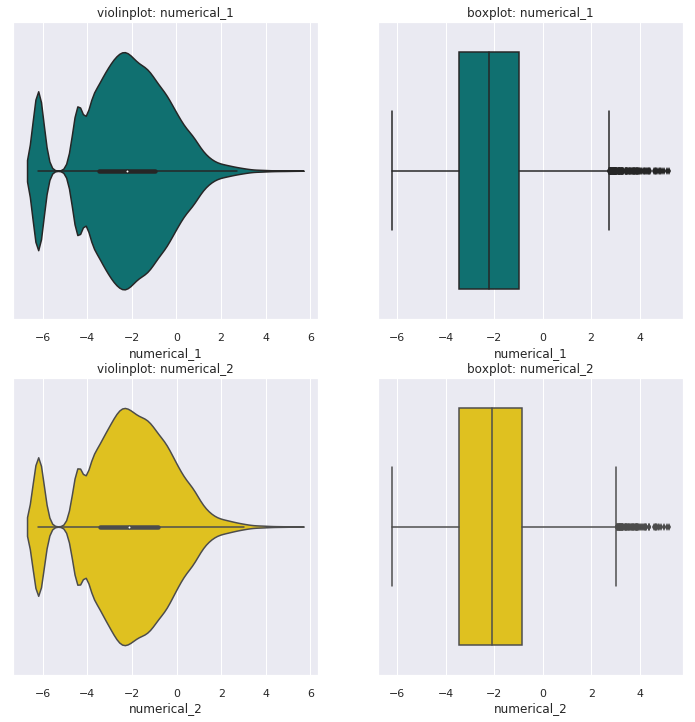

In [36]:
# log 변환
fig, axes = plt.subplots(2, 2, figsize=(12,12))
sns.violinplot(np.log(merchant['numerical_1']), ax=axes[0,0], color='teal').set_title('violinplot: numerical_1')
sns.boxplot(np.log(merchant['numerical_1']), ax=axes[0,1], color='teal').set_title('boxplot: numerical_1')
sns.violinplot(np.log(merchant['numerical_2']), ax=axes[1,0], color='gold').set_title('violinplot: numerical_2')
sns.boxplot(np.log(merchant['numerical_2']), ax=axes[1,1], color='gold').set_title('boxplot: numerical_2')

`numerical_1`과 `numerical_2`가 완전 똑같아보인다. <br>근데 위에서 mean이 달랐으므로 `numerical_1`과 `numerical_2`가 같은 행과 다른 행을 확인하겠다.

In [37]:
print('numerical_1과 numerical_2가 같은 행은 총 {}개로 전체의 {:.2f}%이다.'.format(sum(merchant['numerical_1'] == merchant['numerical_2']), \
                                                                 sum(merchant['numerical_1'] == merchant['numerical_2'])/merchant.shape[0] * 100))
print('numerical_1과 numerical_2가 다른 행은 총 {}개로 전체의 {:.2f}%이다.'.format(sum(merchant['numerical_1'] != merchant['numerical_2']), \
                                                                 sum(merchant['numerical_1'] != merchant['numerical_2'])/merchant.shape[0] * 100))

numerical_1과 numerical_2가 같은 행은 총 301038개로 전체의 89.94%이다.
numerical_1과 numerical_2가 다른 행은 총 33658개로 전체의 10.06%이다.


`numerical_1`과 `numerical_2`가 같은지 다른지를 이용해서 변수를 만들 수도 있겠다.

~~**<merchant\> numerical_1/2 : feature engineering**<br>~~
~~- 로그 변환한 log_numeric_1/2 생성~~

In [38]:
# merchant['log_numeric_1'] = np.log(merchant['numerical_1'])
# merchant['log_numeric_2'] = np.log(merchant['numerical_2'])

In [39]:
# plt.figure(figsize=(6,6))
# sns.scatterplot(x='log_numeric_1', y='log_numeric_2', data=merchant)

~~`numerical_1`과 `numerical_2`가 다른 경우는 모두 `numerical_1`>`numerical_2`이다.~~

- most_recent_sales_range / most_recent_purchase_range <br>
마지막 활동 달의 수익 수준 - 수익 많은 가게 / 마지막 활동 달의 거래량 수준 - 인기있는 가게

In [40]:
merchant['most_recent_sales_range'].unique()
merchant['most_recent_purchases_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

array(['E', 'D', 'C', 'A', 'B'], dtype=object)

In [41]:
merchant.groupby('most_recent_sales_range')['numerical_1'].mean().to_frame().index

Index(['A', 'B', 'C', 'D', 'E'], dtype='object', name='most_recent_sales_range')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a784b668>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a784b668>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a7815ef0>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70a7815ef0>],
      dtype=object)

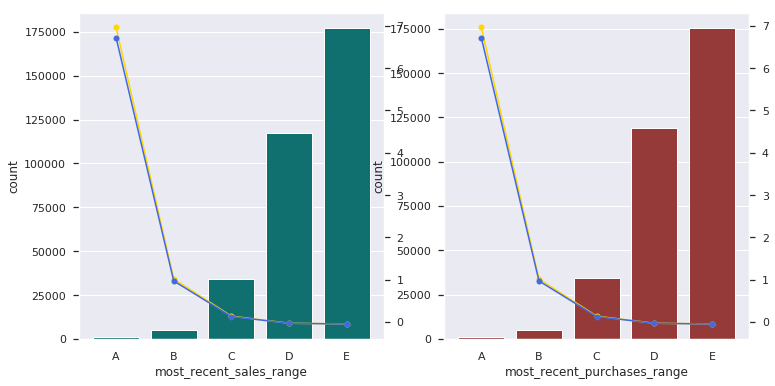

In [42]:
nu_1 = merchant.groupby('most_recent_sales_range')['numerical_1'].mean().to_frame()
nu_2 = merchant.groupby('most_recent_sales_range')['numerical_2'].mean().to_frame()

fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax1 = sns.countplot(merchant['most_recent_sales_range'], order=['A','B','C','D','E'], color='teal', ax=axes[0])
ax2 = sns.countplot(merchant['most_recent_purchases_range'], order=['A','B','C','D','E'], color='brown', ax=axes[1])
nu_1.plot(ax=axes[0], secondary_y=True, marker='o', color='gold', subplots=True, legend=None)
nu_2.plot(ax=axes[0], secondary_y=True, marker='o', color='royalblue', subplots=True, legend=None)
nu_1.plot(ax=axes[1], secondary_y=True, marker='o', color='gold', subplots=True, legend=None)
nu_2.plot(ax=axes[1], secondary_y=True, marker='o', color='royalblue', subplots=True, legend=None)

`numeric_1/2`와 최근 거래/구매량이 관련있어 보인다.

- avg_sales_lag3/6/12

In [43]:
merchant['avg_sales_lag3'].describe()
merchant['avg_sales_lag6'].describe()
merchant['avg_sales_lag12'].describe()

count    334683.000000
mean         13.832993
std        2395.489999
min         -82.130000
25%           0.880000
50%           1.000000
75%           1.160000
max      851844.640000
Name: avg_sales_lag3, dtype: float64

count    3.346830e+05
mean     2.165079e+01
std      3.947108e+03
min     -8.213000e+01
25%      8.500000e-01
50%      1.010000e+00
75%      1.230000e+00
max      1.513959e+06
Name: avg_sales_lag6, dtype: float64

count    3.346830e+05
mean     2.522771e+01
std      5.251842e+03
min     -8.213000e+01
25%      8.500000e-01
50%      1.020000e+00
75%      1.290000e+00
max      2.567408e+06
Name: avg_sales_lag12, dtype: float64

0~1 주변 작은 값들이 대부분이다. <br>
이 값은 $해당기간 평균 수익/최근 1달 수익$ 을 계산한 값이라서, <br>
1이면 수익이 꾸준한 경우, 1보다 작을수록 최근에 인기가 올라간 경우, 1보다 클수록 최근에 인기가 떨어진 경우를 나타낸다.<br>
근데 음수가 왜 있지?

In [44]:
merchant[(merchant['avg_sales_lag3']<0) | (merchant['avg_sales_lag6']<0) | (merchant['avg_sales_lag12']<0)] 

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


Text(0.5, 1.0, 'violinplot: avg_sales_lag3')

Text(0.5, 1.0, 'violinplot: avg_sales_lag6')

Text(0.5, 1.0, 'violinplot: avg_sales_lag12')

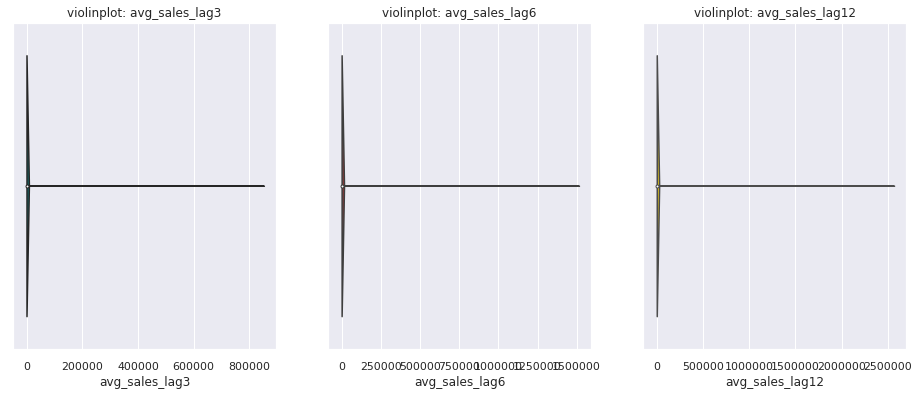

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
sns.violinplot(merchant['avg_sales_lag3'], ax=axes[0], color='teal').set_title('violinplot: avg_sales_lag3')
sns.violinplot(merchant['avg_sales_lag6'], ax=axes[1], color='brown').set_title('violinplot: avg_sales_lag6')
sns.violinplot(merchant['avg_sales_lag12'], ax=axes[2], color='gold').set_title('violinplot: avg_sales_lag12')

이 변수들도 log변환하자.

Text(0.5, 1.0, 'logarithm: avg_sales_lag3')

Text(0.5, 1.0, 'logarithm: avg_sales_lag3')

Text(0.5, 1.0, 'logarithm: avg_sales_lag6')

Text(0.5, 1.0, 'logarithm: avg_sales_lag6')

Text(0.5, 1.0, 'logarithm: avg_sales_lag12')

Text(0.5, 1.0, 'logarithm: avg_sales_lag12')

(-2.5, 15)

(-2.5, 15)

(-2.5, 15)

(-2.5, 15)

(-2.5, 15)

(-2.5, 15)

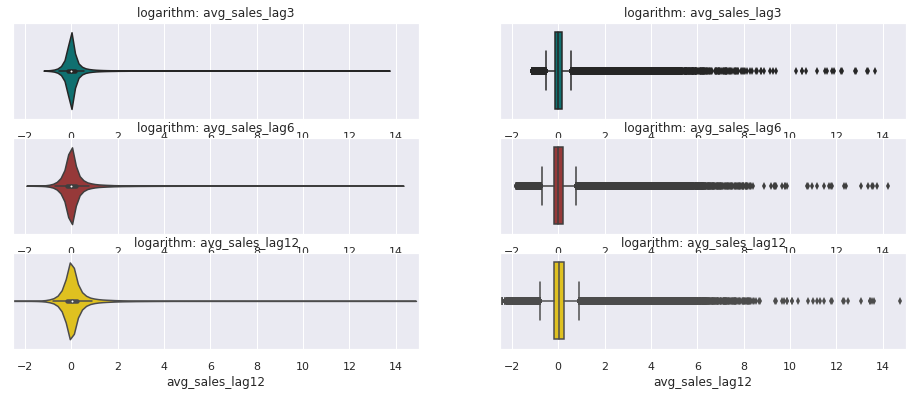

In [46]:
# log 변환
fig, axes = plt.subplots(3, 2, figsize=(16,6))

sns.violinplot(np.log(merchant['avg_sales_lag3']), ax=axes[0,0], color='teal').set_title('logarithm: avg_sales_lag3')
sns.boxplot(np.log(merchant['avg_sales_lag3']), ax=axes[0,1], color='teal').set_title('logarithm: avg_sales_lag3')
sns.violinplot(np.log(merchant['avg_sales_lag6']), ax=axes[1,0], color='brown').set_title('logarithm: avg_sales_lag6')
sns.boxplot(np.log(merchant['avg_sales_lag6']), ax=axes[1,1], color='brown').set_title('logarithm: avg_sales_lag6')
sns.violinplot(np.log(merchant['avg_sales_lag12']), ax=axes[2,0], color='gold').set_title('logarithm: avg_sales_lag12')
sns.boxplot(np.log(merchant['avg_sales_lag12']), ax=axes[2,1], color='gold').set_title('logarithm: avg_sales_lag12')
for i in range(3):
    for j in range(2):
        axes[i,j].set_xlim(-2.5,15)

로그 변환 했으므로 0을 기준으로 생각할 수 있다.<br>
만약 0보다 작으면 최근에 인기가 떨어진 가게, 0보다 크면 최근에 인기가 올라간 가게, 0근처이면 계속 비슷한 수익을 내는 가게로 생각할 수 있다.

- avg_purchases_lag3/6/12

In [47]:
merchant['avg_purchases_lag3'].describe()
merchant['avg_purchases_lag6'].describe()
merchant['avg_purchases_lag12'].describe()

count    3.346960e+05
mean              inf
std               NaN
min      3.334953e-01
25%      9.236499e-01
50%      1.016667e+00
75%      1.146522e+00
max               inf
Name: avg_purchases_lag3, dtype: float64

count    3.346960e+05
mean              inf
std               NaN
min      1.670447e-01
25%      9.022475e-01
50%      1.026961e+00
75%      1.215575e+00
max               inf
Name: avg_purchases_lag6, dtype: float64

count    3.346960e+05
mean              inf
std               NaN
min      9.832954e-02
25%      8.983333e-01
50%      1.043361e+00
75%      1.266480e+00
max               inf
Name: avg_purchases_lag12, dtype: float64

missing value와 inf가 있다. inf와 missing value 개수를 확인하고 얘네를 제외한 분포를 확인하자.

In [48]:
merchant['avg_purchases_lag3'].isna().sum()
merchant['avg_purchases_lag6'].isna().sum()
merchant['avg_purchases_lag12'].isna().sum()

0

0

0

missing value는 없다. inf때문에 계산이 안돼서 NaN으로 나왔나보다.

In [49]:
sum(merchant['avg_purchases_lag3'] == np.inf)
sum(merchant['avg_purchases_lag6'] == np.inf)
sum(merchant['avg_purchases_lag12'] == np.inf)

3

3

3

In [50]:
merchant[(merchant['avg_purchases_lag3'] == np.inf) | (merchant['avg_purchases_lag6'] == np.inf) | (merchant['avg_purchases_lag12'] == np.inf)]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
10,M_ID_492cfa500c,13462,369,27,-0.057471,-0.057471,N,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,N,-1,9,1.0
11,M_ID_73487fed26,17123,427,27,-0.057471,-0.057471,Y,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,Y,-1,-1,NaN
12,M_ID_7149162139,2118,63,27,-0.057471,-0.057471,N,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,Y,88,16,1.0


최근 거래량=0 이라면 inf가 나올 수 있다. (np.divide(3,0)=inf) <br>
inf를 해당 variable의 max값으로 대체하겠다.

**<merchant\> - `avg_purchases_lag3/6/12` : feature engineering** <br>
    np.inf -> max로 대체 

In [51]:
merchant[merchant['avg_purchases_lag3'] != np.inf]['avg_purchases_lag3'].max()
merchant[merchant['avg_purchases_lag6'] != np.inf]['avg_purchases_lag6'].max()
merchant[merchant['avg_purchases_lag12'] != np.inf]['avg_purchases_lag12'].max()

61851.33333333

56077.5

50215.55555556

In [52]:
merchant['avg_purchases_lag3'].replace(np.inf, np.nan, inplace=True)
merchant['avg_purchases_lag6'].replace(np.inf, np.nan, inplace=True)
merchant['avg_purchases_lag12'].replace(np.inf, np.nan, inplace=True)

In [53]:
merchant['avg_purchases_lag3'] = merchant['avg_purchases_lag3'].fillna(merchant[merchant['avg_purchases_lag3'] != np.inf]['avg_purchases_lag3'].max())
merchant['avg_purchases_lag6'] = merchant['avg_purchases_lag6'].fillna(merchant[merchant['avg_purchases_lag6'] != np.inf]['avg_purchases_lag6'].max())
merchant['avg_purchases_lag12'] = merchant['avg_purchases_lag12'].fillna(merchant[merchant['avg_purchases_lag12'] != np.inf]['avg_purchases_lag12'].max())

In [54]:
merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,322809.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,13.832993,2.145143,2.994108,2.165079e+01,2.390194,5.947397,2.522771e+01,2.529277,11.599335,102.917926,11.860942,2.380002
std,31623.043426,252.898046,9.807371,1.098154,1.070497,2395.489999,213.955844,0.095247,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,107.090673,6.176889,1.562661
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,-82.130000,0.333495,1.000000,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000,-1.000000,-1.000000,1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.880000,0.923650,3.000000,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,1.000000,1.016667,3.000000,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,69.000000,9.000000,2.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,1.160000,1.146522,3.000000,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,851844.640000,61851.333333,3.000000,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,347.000000,24.000000,5.000000


- active_months_lag3/6/12

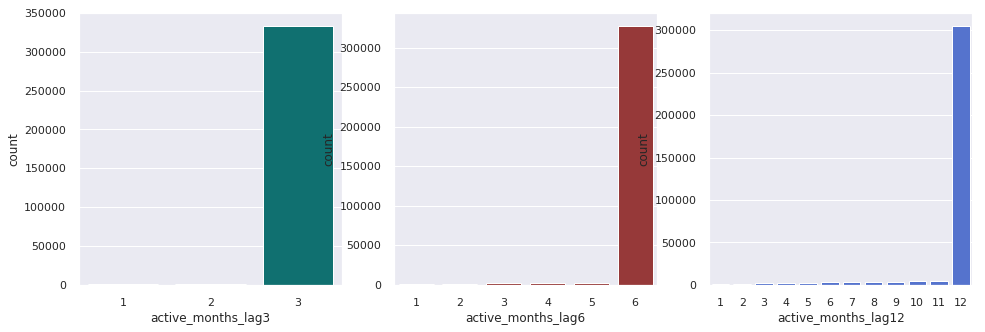

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.countplot(merchant['active_months_lag3'], ax=axes[0], color='teal')
sns.countplot(merchant['active_months_lag6'], ax=axes[1], color='brown')
sns.countplot(merchant['active_months_lag12'], ax=axes[2], color='royalblue')

In [57]:
print('1개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 1]['merchant_id'].count()/merchant.shape[0] *100))
print('2개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 2]['merchant_id'].count()/merchant.shape[0] *100))
print('3개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 3]['merchant_id'].count()/merchant.shape[0] *100))
print('4개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 4]['merchant_id'].count()/merchant.shape[0] *100))
print('5개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 5]['merchant_id'].count()/merchant.shape[0] *100))
print('6개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 6]['merchant_id'].count()/merchant.shape[0] *100))
print('7개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 7]['merchant_id'].count()/merchant.shape[0] *100))
print('8개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 8]['merchant_id'].count()/merchant.shape[0] *100))
print('9개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 9]['merchant_id'].count()/merchant.shape[0] *100))
print('10개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 10]['merchant_id'].count()/merchant.shape[0] *100))
print('11개월 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 11]['merchant_id'].count()/merchant.shape[0] *100))
print('12개월 또는 그보다 더 전에 생긴 가게는 전체의 {:.4f}%이다.'.format(merchant[merchant['active_months_lag12'] == 12]['merchant_id'].count()/merchant.shape[0] *100))

1개월 전에 생긴 가게는 전체의 0.1607%이다.
2개월 전에 생긴 가게는 전체의 0.2677%이다.
3개월 전에 생긴 가게는 전체의 0.4936%이다.
4개월 전에 생긴 가게는 전체의 0.6125%이다.
5개월 전에 생긴 가게는 전체의 0.6800%이다.
6개월 전에 생긴 가게는 전체의 0.8178%이다.
7개월 전에 생긴 가게는 전체의 0.9782%이다.
8개월 전에 생긴 가게는 전체의 1.1222%이다.
9개월 전에 생긴 가게는 전체의 1.1425%이다.
10개월 전에 생긴 가게는 전체의 1.2378%이다.
11개월 전에 생긴 가게는 전체의 1.3293%이다.
12개월 또는 그보다 더 전에 생긴 가게는 전체의 91.1576%이다.


이걸 통해서 얼마나 최근에 생긴 가게인지 알 수 있겠다. <br>
근데 last_active_month(기준 일자)를 알아야되는데... 그건 다 똑같나? 언제 확인한 값이지?

#### ◀ 정리 ▶

* [`avg_sales_lag3`, `avg_sales_lag6`, `avg_sales_lag12`, `category_2`] 결측치 있음
* merchant_id : 중복되는 애들 어떻게 처리할지 고민
* `subsector_id`와 `merchant_category_id` : 계층구조 + 모두 -1인 경우가 있는데 이건 아무래도 missing value인 것 같다.
* `state_id`와 `city_id` : 계층구조라고 할 수 있을까?(-1이 25개의 서로 다른 `state_id`에 분포) + `state_id`=-1인 경우엔 `city_id`가 -1뿐. missing value인 듯!
* `numerical_1/2`와 최근 거래량/수익은 관련이 있음.
* 추후에 어떤 특징을 가져야 매출과 거래량이 많은지 확인할 것 or 비슷한 특징을 가진 가게들을 클러스터링
* sales/purchases + 다른 특성들 - 더 알아볼 것
* merchant의 last_active_month는 모두 동일? 알 수 있는 방법이 있나?
* `avg_purchases_lag3/6/12`의 inf값은 max값으로 대체
* **merchant table을 모델링에 어떻게 활용할 수 있을까?**